# `fitgrid` EEG modeling

1. Read or construct a 2-D pandas.DataFrame() of time-stamped epochs with time series observations in rows and variables in columns.

In [1]:
import pandas as pd
import fitgrid as fg

from fitgrid import sample_data, DATA_DIR

# fitgrid built-in sample data download
p3_f = "sub000p3.ms1500.epochs.feather"
sample_data.get_file(p3_f)

# read as a pandas.DataFrame
p3_df = pd.read_feather(DATA_DIR / p3_f)
p3_df["time_ms"] = p3_df["match_time"]

# EEG quality control (specific to these data)
good_epoch_ids = p3_df.query("time_ms == 0 and log_flags == 0")["epoch_id"]
p3_df = p3_df.query("epoch_id in @good_epoch_ids")

# select EEG channels ("left hand side") and predictor variables ("right hand side")
columns_of_interest = [
    "epoch_id",
    "time_ms",  # index columns
    "MiPf",
    "MiCe",
    "MiPa",
    "MiOc",  # EEG
    "stim",
    "tone",  # predictors
]
p3_df = p3_df[columns_of_interest].query("stim in ['standard', 'target']")
p3_df

,epoch_id,time_ms,MiPf,MiCe,MiPa,MiOc,stim,tone
0,0,-748,-54.5,2.781250,-8.828125,-17.734375,target,hi
1,0,-744,-56.5,-4.046875,-11.929688,-15.304688,target,hi
2,0,-740,-55.5,-3.289062,-4.769531,-11.171875,target,hi
3,0,-736,-60.5,-2.529297,0.954102,-8.742188,target,hi
4,0,-732,-57.0,4.046875,9.781250,-8.015625,target,hi
...,...,...,...,...,...,...,...,...
146995,391,732,9.5,3.289062,15.265625,4.617188,standard,hi
146996,391,736,15.5,9.359375,21.234375,10.929688,standard,hi
146997,391,740,9.0,3.792969,15.507812,7.773438,standard,hi
146998,391,744,7.5,4.300781,15.507812,10.445312,standard,hi


2. Load the epochs data into fitgrid for modeling

In [2]:
p3_df.set_index(['epoch_id', 'time_ms'], inplace=True)
p3_epochs_fg = fg.epochs_from_dataframe(
    p3_df,
    epoch_id='epoch_id',
    time='time_ms',
    channels=['MiPf', 'MiCe', 'MiPa', 'MiOc'],
)


3. Fit a model (formula) to the observations at each timepoint and channel.

In [3]:
lm_grid = fg.lm(
    p3_epochs_fg,
    RHS="1 + stim",
    LHS=["MiPf", "MiCe", "MiPa", "MiOc"]
)

100%|██████████| 375/375 [00:07<00:00, 47.24it/s]


4. The `FitGrid[time, channel]` object is a container for the model fits.

In [4]:
lm_grid

375 by 4 LMFitGrid of type <class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>.

Slice it like a dataframe by times and/or channelsl

In [5]:
lm_grid[-200:600, ["MiCe", "MiPa"]]

201 by 2 LMFitGrid of type <class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>.

Access attributes by name like a single fit.
The results come back as a :py:class:`pandas.DataFrame` or another
FitGrid[time, channel].

In [6]:
# estimated predictor coefficients (betas)
lm_grid.params

MiPf      MiCe      MiPa      MiOc
time_ms                                                       
-748    Intercept       0.555357  0.622325  0.537183  0.537796
        stim[T.target] -1.629431 -0.650356  1.812896  0.172689
-744    Intercept       0.625000  0.752215  0.778320  0.886097
        stim[T.target] -1.699074 -0.570158  1.514260 -0.373456
-740    Intercept       0.608929  0.557471  0.764853  0.855045
...                          ...       ...       ...       ...
 740    stim[T.target]  3.248743 -4.827724  3.147743  6.882054
 744    Intercept      -3.739286  0.399466 -2.147158 -2.736217
        stim[T.target]  2.933730 -4.362466  3.348492  6.483034
 748    Intercept      -3.546429  0.501329 -1.988685 -2.539163
        stim[T.target]  3.314947 -3.494023  4.055598  6.529904

[750 rows x 4 columns]

In [7]:
# coefficient standard errors
lm_grid.bse

MiPf      MiCe      MiPa      MiOc
time_ms                                                       
-748    Intercept       2.266858  1.031282  1.103042  0.827461
        stim[T.target]  5.637684  2.564802  2.743268  2.057898
-744    Intercept       2.282165  1.041583  1.114084  0.834884
        stim[T.target]  5.675751  2.590421  2.770730  2.076360
-740    Intercept       2.299236  1.072554  1.136802  0.843092
...                          ...       ...       ...       ...
 740    stim[T.target]  3.448114  2.392097  2.577733  2.126860
 744    Intercept       1.391841  0.954694  1.019806  0.843689
        stim[T.target]  3.461514  2.374328  2.536261  2.098256
 748    Intercept       1.402404  0.949739  1.005072  0.835853
        stim[T.target]  3.487782  2.362003  2.499617  2.078769

[750 rows x 4 columns]

In [8]:
# model log likelihood.
lm_grid.llf

,MiPf,MiCe,MiPa,MiOc
time_ms,,,,
-748,-1687.276217,-1424.220520,-1446.688241,-1350.675012
-744,-1689.523891,-1427.540120,-1450.015114,-1353.657959
-740,-1692.013012,-1437.326457,-1456.757348,-1356.925480
-736,-1691.655361,-1439.900643,-1453.119704,-1345.964506
-732,-1690.666053,-1438.338094,-1451.033305,-1351.582890
...,...,...,...,...
732,-1523.746525,-1409.895567,-1441.242080,-1384.302921
736,-1524.821058,-1403.760612,-1431.363348,-1371.737200
740,-1523.066518,-1400.937000,-1425.900151,-1361.684189


Plot results with a fitgrid built-in.

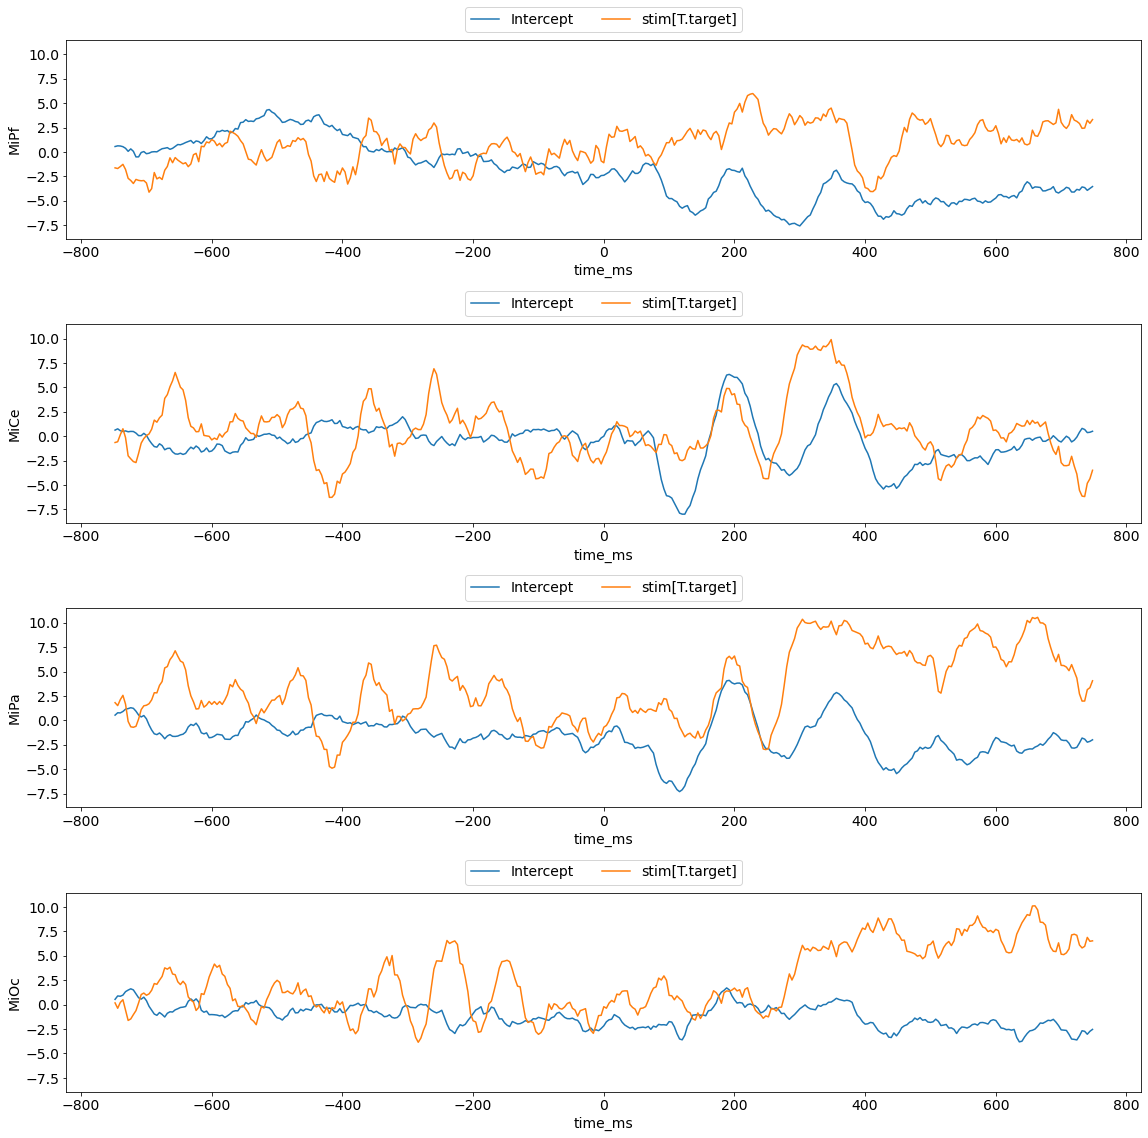

In [9]:
f, axs = lm_grid.plot_betas()

Or make your own with pandas, matplotlib, seaborn, etc..

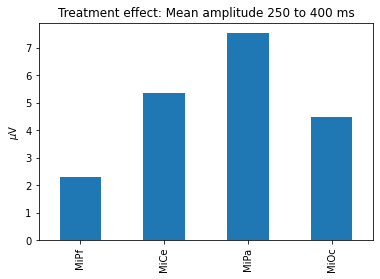

In [10]:
from matplotlib import pyplot as plt

# Slice a time range and compute means with pandas
p3_effect = lm_grid.params.loc[
    pd.IndexSlice[250:400, "stim[T.target]"], :
].mean()

ax = p3_effect.plot.bar()
ax.set_title("Treatment effect: Mean amplitude 250 to 400 ms")
_ = ax.set(ylabel="$\mu$V")

5. Compare grid summaries for models sets and pairs.

In [11]:
from fitgrid.utils import summary as fgs

p3_summaries = fgs.summarize(
    p3_epochs_fg,
    modeler="lm",
    RHS=["1 + stim + tone", "1 + stim", "1 + tone", "1"],
    LHS=["MiPf", "MiCe", "MiPa", "MiOc"],
)
p3_summaries

100%|██████████| 375/375 [00:00<00:00, 1250.25it/s]


MiPf          MiCe  \
time_ms model           beta      key                                        
-748    1 + stim + tone Intercept 2.5_ci           -6.503946     -3.857680   
                                  97.5_ci           5.533294      1.591338   
                                  AIC            3380.292996   2850.856368   
                                  DF              331.000000    331.000000   
                                  Estimate         -0.485326     -1.133171   
...                                                      ...           ...   
 748    1               Intercept SSresid      183325.213323  84402.889127   
                                  T-stat           -2.344876     -0.072978   
                                  has_warning       0.000000      0.000000   
                                  logLike       -1527.340759  -1397.805528   
                                  sigma2          550.526166    253.462130   

                                                       MiPa          MiOc  
time_ms model           beta      key                                      
-748    1 + stim + tone Intercept 2.5_ci          -4.059197     -2.997439  
                                  97.5_ci          1.775272      1.376619  
                                  AIC           2896.512769   2704.067358  
                                  DF             331.000000    331.000000  
                                  Estimate        -1.141962     -0.810410  
...                                                     ...           ...  
 748    1               Intercept SSresid      94649.943726  66876.807339  
                                  T-stat          -1.444980     -1.913042  
                                  has_warning      0.000000      0.000000  
                                  logLike      -1416.940998  -1358.936378  
                                  sigma2         284.234065    200.831253  

[36000 rows x 4 columns]

Compare models on Akiake's information criterion (AIC) as
the difference between the model's AIC and the
lowest in the set.  Larger AIC differences indicate relatively
less support for the model in comparison with the alternative(s).

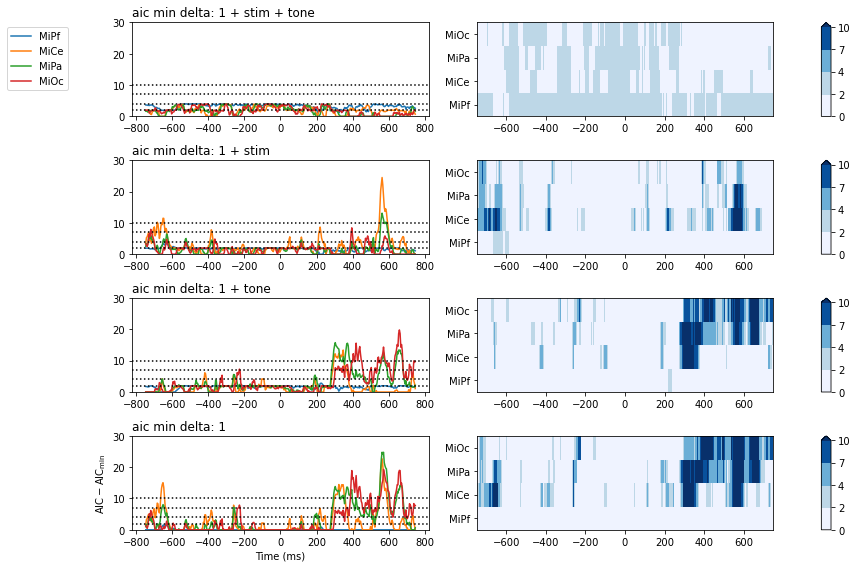

In [12]:
fig, axs = fgs.plot_AICmin_deltas(p3_summaries)
for axi in axs:
    axi[0].set(ylim=(0, 30))
axs[-1][0].set(xlabel="Time (ms)", ylabel="$\mathsf{AIC - AIC_{min}}$")
fig.tight_layout()